In [1]:
import sys
sys.path.append('../../../../src')
from common import common, transform, json
from common.functions import normalize_vector, cos_similarity, gauss
from tracker import main as tr
from individual_activity import main as ia
from group_activity import main as ga
from display.heatmap import Heatmap
from display.display import display
from common.video import Video
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Indivisual Activity をロード

In [2]:
room_num = '09'
date = '20210304'
name = 'gaze1-1'

In [3]:
individual_activity_json = os.path.join(
    common.data_dir, '{0}/{1}/{2}/json/individual_activity.json'.format(room_num, date, name))
field_path = os.path.join(common.data_dir, '{}/field0304.png'.format(room_num))

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = common.homo[room_num + '_0304'][0]
p_field = common.homo[room_num + '_0304'][1]
homo = transform.Homography(p_video, p_field, field_raw.shape)

In [5]:
individual_activity_data = json_io.load(individual_activity_json)

In [6]:
from common.json_io import IA_FORMAT
from individual_activity.individual_activity import IndividualActivity

def make_individuals(datas, homo):
    individuals = {}
    for data in datas:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        for key in IA_FORMAT[3:]:
            ia.indicator_dict[key][frame_num] = data[key]
            
    return list(individuals.values())

In [7]:
individuals = make_individuals(individual_activity_data, homo)

# 顔の動きを時系列化

  0%|                                                                                                                                                                  | 0/589 [00:00<?, ?it/s]/Users/koji/program/research/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 589/589 [00:00<00:00, 24380.19it/s]


<AxesSubplot:>

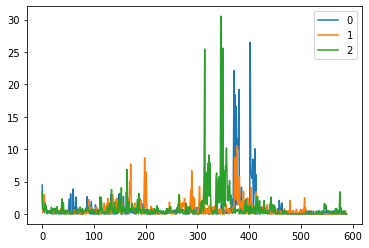

In [8]:
max_frame_num = max([max(individual.tracking_points.keys()) for individual in individuals])

face_changes = []
for frame_num in tqdm(range(1, max_frame_num)):
    face_change = {}
    
    for individual in individuals:
        pre_face = individual.get_data('face_vector', frame_num - 1)
        face = individual.get_data('face_vector', frame_num)
        if pre_face is None or face is None:
            continue
        shita = np.arccos(np.dot(pre_face, face))

        face_change[individual.id] = np.rad2deg(shita)
        
    face_changes.append(face_change)
    
df = pd.DataFrame.from_dict(face_changes)
df = df.iloc[:, :3]
df = df.fillna(0)
df.plot()

# K-NNで異常検知

In [32]:
from sklearn.neighbors import NearestNeighbors

In [128]:
def embed(lst, dim):
    emb = np.empty((0, dim), float)
    for i in range(lst.shape[0] - dim + 1):
        tmp = np.array(lst[i:i + dim])[::-1].reshape(1, -1)
        emb = np.append(emb, tmp, axis=0)
    return emb

In [147]:
train_len = 200
window = 10

train_data = df.iloc[:train_len, 0]
train = embed(train_data, window)

test_datas = [df.iloc[train_len:, i] for i in range(df.shape[1])]
tests = [embed(test_data, window) for test_data in test_datas]

In [149]:
model = NearestNeighbors(n_neighbors=1)
model.fit(train)

NearestNeighbors(n_neighbors=1)

In [150]:
pred = [model.kneighbors(test)[0] for test in tests]

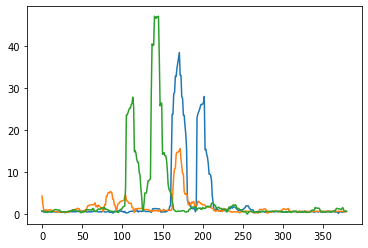

In [153]:
plt.plot(pred[0])
plt.plot(pred[1])
plt.plot(pred[2])